In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
# read flash.dat to a list of lists
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata as gd

In [2]:
def ijk(i, j, k, Nx, Ny, Nz):
    """
    A map from 1D flattened date to 3D simulatio results
    """
    return [(((i) * (Ny + 1)) + (j)) * (Nz + 1) + (k)]

def gene_data(f, xl, Nx, dx, yl, Ny, dy, zl, Nz, dz):
    data_gen = np.zeros((Nx+1)*(Ny+1)*(Nz+1))
    for i in range(Nx+1):
        for j in range(Ny+1):
            for k in range(Nz+1):
                data_gen[ijk(i, j, k, Nx, Ny, Nz)] = f(xl+i*dx, yl+j*dy, zl+k*dz)
    return data_gen

In [10]:
def get_normsimp(df, Nx, Ny, Nz):
    """
    Function obtaining norm of the input data by Simpson's 1/3 rule
    """
    xr = df.X.max()
    xl = df.X.min()
    yr = df.Y.max()
    yl = df.Y.min()
    zr = df.Z.max()
    zl = df.Z.min()
    dx = (xr-xl)/Nx
    dy = (yr-yl)/Ny
    dz = (zr-zl)/Nz
    dd = df.dens
    normz = np.zeros((Nx+1, Ny+1))
    normy = np.zeros((Nx+1))
    norm = 0
    for i in range(Nx+1):
        for j in range(Ny+1):
            normz[i,j] = dd[(((i) * (Ny + 1)) + (j)) * (Nz + 1)+0] \
            + 2*sum(dd[(((i) * (Ny + 1)) + (j)) * (Nz + 1):(((i) * (Ny + 1)) + (j)) * (Nz + 1)+Nz-2:2]) \
            + 4*sum(dd[(((i) * (Ny + 1)) + (j)) * (Nz + 1)+1:(((i) * (Ny + 1)) + (j)) * (Nz + 1)+Nz-1:2]) \
            + dd[(((i) * (Ny + 1)) + (j)) * (Nz + 1)+ Nz-1]

    for i in range(Nx+1):
        normy[i] = normz[i, 0] \
        + 2*sum(normz[i, :Ny-2:2]) \
        + 4*sum(normz[i, 1:Ny-1:2]) \
        + normz[i, Ny-1]

    norm = normy[0] \
    + 2*sum(normy[:Nx-2:2]) \
    + 4*sum(normy[1:Nx-1:2]) \
    + normy[Nx-1]

    return norm*dx*dy*dz/27

In [4]:
def rot_curve(dfd, n, M0, T0, L0, G0):
    """
    Function calculating the rotation curve given number density
    """
    dfd["r"] = np.sqrt(dfd.X**2+dfd.Y**2+dfd.Z**2)
    rmax = dfd.r.max()
    rmin = dfd.r.min()
    rarr = np.linspace(rmin, rmax, n)[1:]
    Narr = []
    for ri in rarr:
        dfdr = dfd[dfd.r<=ri]
        Narr.append(dfdr.dens.sum()*dxd*dyd*dzd)
    Varr = G0*((np.array(Narr)*M0)/rarr)**0.5 *L0/T0
    return rarr, Narr, Varr

# Test ground state wave function

3.5887531466733815 0.17553743576132633 0.012566370614359173 1.5874010519681994 0.5083258231690274


Text(0.5, 1.0, 'TF on Z axis')

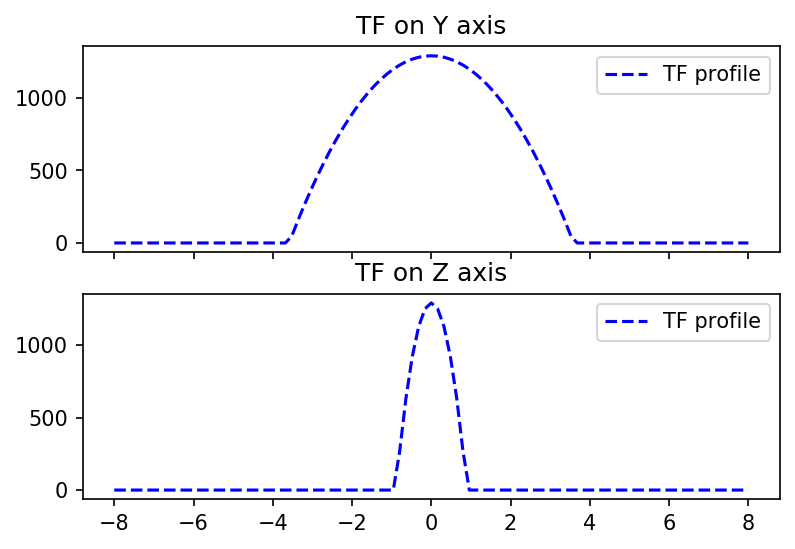

In [5]:
# parameters for this simulation
N = 100000 # number of particles
pi = 4 * np.arctan(1) 
omgx = 1.0 # trap frequency along x and y direction
z2x = 4 # Ration between the trap frequency of z and x
omgz = omgx*z2x # trap frequency along z direction
omg = (omgx*omgx*omgz)**(1/3) 
aho = 1/np.sqrt(omg)
a = 0.001 # self interaction: s-wave scattering length
g = 4*pi*a

R = (15*N*a/aho)**(1/5)*aho       # radius of condensate
Rc = (15*N*a/aho)**(1/5)*aho       # radius of condensate
rh = R*(aho/R)**2                    # healing length
# omgc = 5/(2*R**2)*np.log(R/rh)
omgc = 5/(2*R**2)*np.log(0.671*R/rh) # Critical angular velocity to generate vortices
mu = omg/2*(15*N*a/aho)**(2/5)
print(R, rh, g, omg, omgc)
def fermiFunc(x, y, z):
    n = (mu-1/2*omg**2*(x**2+y**2+(z2x*z)**2))/g
    n_mask = n<0
    n[n_mask] = 0
    return n

xd= np.linspace(-8, 8, 100+1)
yd= np.linspace(-8, 8, 100+1)
zd= np.linspace(-8, 8, 100+1)


fig, (ax1, ax2) = plt.subplots(2, 1, dpi=150, sharex=True, sharey=True)


ax1.plot(yd, fermiFunc(0,yd,0), 'b--', label="TF profile")
ax1.legend()
# # ax2 = fig.add_subplot(212)
# # ax2.plot(z, dfVz.phi, 'b*', label="trap simulation")
ax1.set_title(r'TF on Y axis')

ax2.plot(zd, fermiFunc(0,0,zd), 'b--', label="TF profile")
ax2.legend()
# ax2 = fig.add_subplot(212)
# ax2.plot(z, dfVz.phi, 'b*', label="trap simulation")
ax2.set_title(r'TF on Z axis')

In [6]:
#densX0004065_0.6.dat
#densX0003150_0.8.dat
#densX0000650_0.45.dat
#densX0000650_0.4.dat
#densX0000650_0.0.dat

file_prefix = "./"
dfd = pd.read_csv(file_prefix+"densX0000650_0.45.dat", sep=" ",  names=["X","Y","Z","dens"])
# datad = np.array([dfd.X.values, dfd.Y.values, dfd.Z.values, dfd.dens.values])
Nxd = 100
Nyd = 100
Nzd = 20
xrd = dfd.X.max()
xld = dfd.X.min()
yrd = dfd.Y.max()
yld = dfd.Y.min()
zrd = dfd.Z.max()
zld = dfd.Z.min()
dxd = (xrd-xld)/Nxd
dyd = (yrd-yld)/Nyd
dzd = (zrd-zld)/Nzd
print((Nxd+1)*(Nyd+1)*(Nzd+1))
print([xld,dxd,Nxd,yld,dyd,Nyd,zld,dzd,Nzd])
dfd

214221
[-8.0, 0.16, 100, -8.0, 0.16, 100, -2.0, 0.2, 20]


,X,Y,Z,dens
0,-8.0,-8.0,-2.0,0.0
1,-8.0,-8.0,-1.8,0.0
2,-8.0,-8.0,-1.6,0.0
3,-8.0,-8.0,-1.4,0.0
4,-8.0,-8.0,-1.2,0.0
...,...,...,...,...
214216,8.0,8.0,1.2,0.0
214217,8.0,8.0,1.4,0.0
214218,8.0,8.0,1.6,0.0
214219,8.0,8.0,1.8,0.0


(101, 4)
(21, 4)


Text(0.5, 1.0, 'Simulation on Z axis, $\\Omega=0.45$')

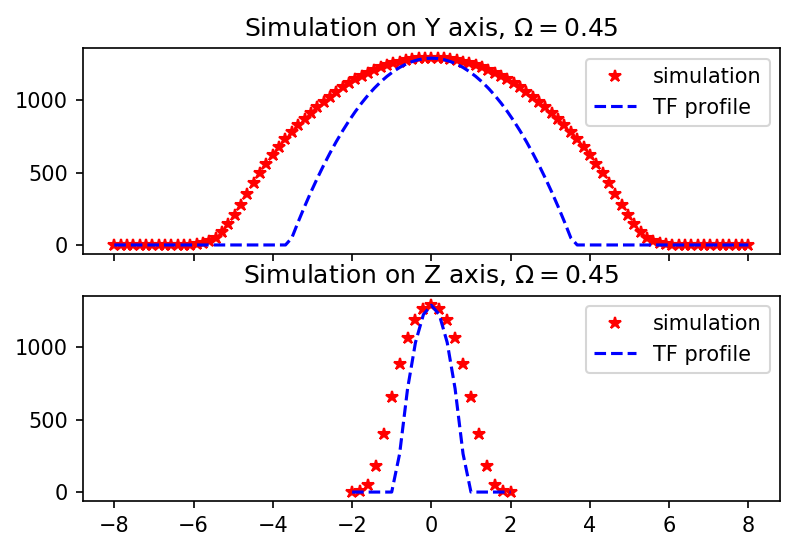

In [7]:
# Take the y axis where x and z are 0
dfzd = dfd[(dfd.X == 0)&(dfd.Z == 0)]
print(dfzd.shape)
xd= np.linspace(xld, xrd, Nxd+1)
yd= np.linspace(yld, yrd, Nyd+1)
zd= np.linspace(zld, zrd, Nzd+1)

fig, (ax1, ax2) = plt.subplots(2, 1, dpi=150, sharex=True, sharey=True)

ax1.plot(yd, dfzd.dens, 'r*', label="simulation")
ax1.plot(yd, fermiFunc(0,yd,0), 'b--', label="TF profile")
#ax1.set_xscale('log')
ax1.legend()
# # ax2 = fig.add_subplot(212)
# # ax2.plot(z, dfVz.phi, 'b*', label="trap simulation")
ax1.set_title(r'Simulation on Y axis, $\Omega=0.45$')
dfzd = dfd[(dfd.X == 0)&(dfd.Y == 0)]
print(dfzd.shape)
ax2.plot(zd, dfzd.dens, 'r*', label="simulation")
ax2.plot(zd, fermiFunc(0,0,zd), 'b--', label="TF profile")
ax2.legend()
# ax2 = fig.add_subplot(212)
# ax2.plot(z, dfVz.phi, 'b*', label="trap simulation")
ax2.set_title(r'Simulation on Z axis, $\Omega=0.45$')

# Rotation Curve Calculation

Text(0.5, 1.0, 'Rotation curve')

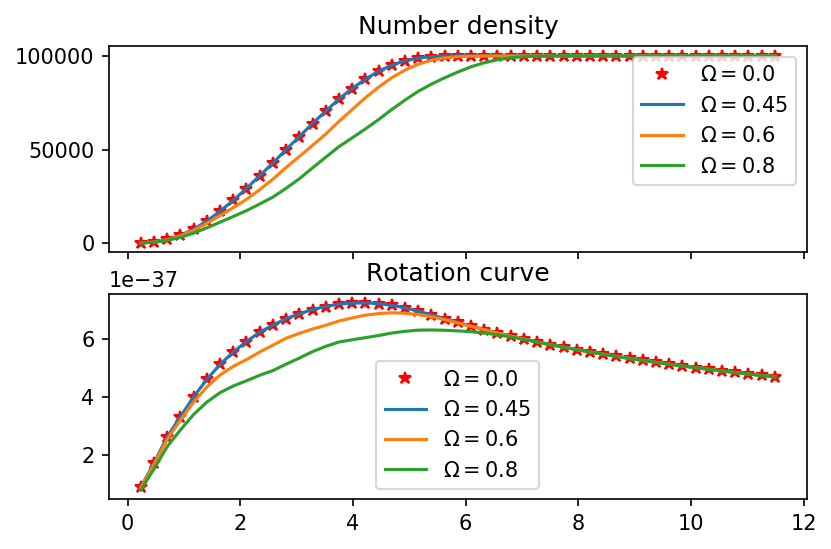

In [17]:
#densX0004065_0.6.dat
#densX0003150_0.8.dat
#densX0000650_0.45.dat
#densX0000650_0.4.dat
#densX0000650_0.0.dat

M0 = 1.445e-25
T0 = 0.016
L0 = 3.42e-6
G0 = 6.6743e-11 * M0 * T0**2 / L0**3  #Choice of Unit

N = 100000 #Total number of particles
n = 50 # number of r array is n-1, to avoid division by 0

file_prefix = "./"
dfd0 = pd.read_csv(file_prefix+"densX0000650_0.0.dat", sep=" ",  names=["X","Y","Z","dens"])
dfd1 = pd.read_csv(file_prefix+"densX0000650_0.45.dat", sep=" ",  names=["X","Y","Z","dens"])
dfd2 = pd.read_csv(file_prefix+"densX0004065_0.6.dat", sep=" ",  names=["X","Y","Z","dens"])
dfd3 = pd.read_csv(file_prefix+"densX0003150_0.8.dat", sep=" ",  names=["X","Y","Z","dens"])

# Renormalize the number density according to total number 
dfd0.dens *= N/get_normsimp(dfd0, Nxd, Nyd, Nzd)
dfd1.dens *= N/get_normsimp(dfd1, Nxd, Nyd, Nzd)
dfd2.dens *= N/get_normsimp(dfd2, Nxd, Nyd, Nzd)
dfd3.dens *= N/get_normsimp(dfd3, Nxd, Nyd, Nzd)


rarr0, Narr0, Varr0 = rot_curve(dfd0, n, M0, T0, L0, G0)
rarr1, Narr1, Varr1 = rot_curve(dfd1, n, M0, T0, L0, G0)
rarr2, Narr2, Varr2 = rot_curve(dfd2, n, M0, T0, L0, G0)
rarr3, Narr3, Varr3 = rot_curve(dfd3, n, M0, T0, L0, G0)

fig, (ax1, ax2) = plt.subplots(2, 1, dpi=150, sharex=True)

ax1.plot(rarr0, Narr0, "r*", label=r'$\Omega=0.0$')
ax1.plot(rarr1, Narr1, label=r'$\Omega=0.45$')
ax1.plot(rarr2, Narr2, label=r'$\Omega=0.6$')
ax1.plot(rarr3, Narr3, label=r'$\Omega=0.8$')
#ax1.set_xscale('log')
ax1.legend()
# # ax2 = fig.add_subplot(212)
# # ax2.plot(z, dfVz.phi, 'b*', label="trap simulation")
ax1.set_title(r'Number density')

ax2.plot(rarr0, Varr0, "r*",  label=r'$\Omega=0.0$')
ax2.plot(rarr1, Varr1, label=r'$\Omega=0.45$')
ax2.plot(rarr2, Varr2, label=r'$\Omega=0.6$')
ax2.plot(rarr3, Varr3, label=r'$\Omega=0.8$')
#ax1.set_xscale('log')
ax2.legend()
# # ax2 = fig.add_subplot(212)
# # ax2.plot(z, dfVz.phi, 'b*', label="trap simulation")
ax2.set_title(r'Rotation curve')

In [8]:
#Creating 3D grid
x=dfd.X
y=dfd.Y
z=dfd.Z
v=dfd.dens

gdN=11

xi,yi,zi=np.ogrid[-8:8:gdN, -8:8:gdN, -2:2:gdN]
X1=xi.reshape(xi.shape[0],)
Y1=yi.reshape(yi.shape[1],)
Z1=zi.reshape(zi.shape[2],)
ar_len=len(X1)*len(Y1)*len(Z1)
X=np.arange(ar_len,dtype=float)
Y=np.arange(ar_len,dtype=float)
Z=np.arange(ar_len,dtype=float)
l=0
for i in range(0,len(X1)):
    for j in range(0,len(Y1)):
        for k in range(0,len(Z1)):
            X[l]=X1[i]
            Y[l]=Y1[j]
            Z[l]=Z1[k]
            l=l+1
            
#interpolate density profile data to the grid (To reduce data size)
V = gd((x,y,z), v, (X,Y,Z), method='linear')


Text(0.5, 0, 'Z')

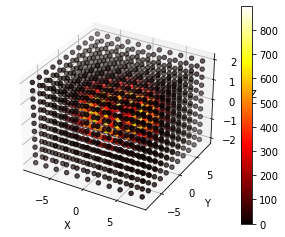

In [340]:
fig2 = plt.figure()
ax2=fig2.gca(projection='3d')
sc2=ax2.scatter(X, Y, Z, c=V, cmap=plt.hot())
plt.colorbar(sc2)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

In [351]:
#interpolate 3D volumn (Create function of arbitrary point)

from scipy.interpolate import RegularGridInterpolator
from numpy import linspace, zeros, array
gdN = 11
x_0 = linspace(-8,8,gdN)
y_0 = linspace(-8,8,gdN)
z_0 = linspace(-2,2,gdN)
V_0 = zeros((gdN,gdN,gdN))
for i in range(gdN):
    for j in range(gdN):
        for k in range(gdN):
            V_0[i,j,k] = V[i*len(x_0)*len(x_0)+j*len(y_0)+k]  #map the 3D coord to 1D array
fn = RegularGridInterpolator((x_0,y_0,z_0), V_0) #Interpolate in the 3D coord

print(fn([0,1,2]))

#fig3 = plt.figure()
#ax3=fig3.gca(projection='3d')
#sc3=ax3.scatter(X, Y, Z, c=V_0, cmap=plt.hot())
#plt.colorbar(sc3)
#ax3.set_xlabel('X')
#ax3.set_ylabel('Y')
#ax3.set_zlabel('Z')

[-2.7975489e-16]


In [343]:
pt= 10 #iteration in for loop 

def M(r):  #calculate Mass(or number of particle) enclosed by radius r
    if(r>2):
        z_n=2  #restricting z within 2
    else:
        z_n=r
    x_r=np.linspace(0,r,pt)
    y_r=np.linspace(0,r,pt)
    z_r=np.linspace(0,z_n,pt)

    Vsum=[]
    for x_i in range(pt):
        Vx=[]
        for y_i in range(pt):
            Vy=[]
            for z_i in range(pt):
                Vz=[]
                z_ma = []
                for i in range(pt):
                    z_ma.append([x_r[x_i],y_r[y_i],z_r[i]])
                Vz = fn(z_ma)
                Zsum = (2*sum(Vz[1:pt-1])+Vz[0]+Vz[pt-1])*r/2/pt
                Vy.append(Zsum)
            Ysum = (2*sum(Vy[1:pt-1])+Vy[0]+Vy[pt-1])*r/2/pt
            Vx.append(Ysum)
        Xsum = (2*sum(Vx[1:pt-1])+Vx[0]+Vx[pt-1])*r/2/pt
        Vsum.append(Xsum)
    
    return (2*sum(Vsum[1:pt-1])+Vsum[0]+Vsum[pt-1])*r/2/pt

M(8)

200434.24967630534

<ipython-input-345-aa743d89f3e2>:8: RuntimeWarning: invalid value encountered in double_scalars
  v_arr.append(G0*(M(r_arr[i])/r_arr[i])**0.5 *L0/T0)


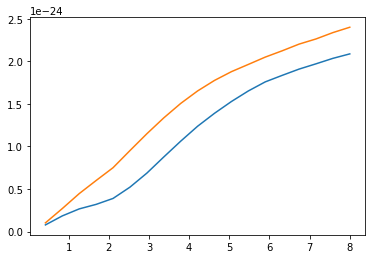

In [345]:
M0 = 1.445e-25
T0 = 0.016
L0 = 3.42e-6
G0 = 6.6743e-11 * M0 * T0**2 / L0**3  #Choice of Unit

r_arr=np.linspace(0,8,20)
v_arr= []
for i in range(20):
    v_arr.append(G0*(M(r_arr[i])/r_arr[i])**0.5 *L0/T0)  #plotting the circular velocity base on Virial Thm
plt.plot(r_arr,v_arr)
#plt.plot(r_arr,v_arr_nr)

#r_arr=np.linspace(0,8,20)
#M_arr_nr= []
#for i in range(20):
#    M_arr_nr.append(M(r_arr[i]))
#plt.plot(r_arr,M_arr_nr)